In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Metropolis-Hastings algorithm for simulation of protein interaction

#### Goals and questions
- Define the interaction matrix randomly (+) Is it better if I define it one time for all of the samples or randomly set it every time I calculate the Boltzmann factor?
- Implement covariances, MI and others and plot the figure 3 figures (-)
- How do we calculate TP fraction?

#### Further exploration:
- Cross attention on two different sequences (?)
- Read the stuff sent by Luca (?)

In [11]:
def set_interaction_mat(x, prob=[0.7,0.3]):
    J = np.random.choice([0,1],(x.shape[0],x.shape[0]),p=prob) # interaction matrix
    return J

def energy(x, T, J):
    # Function that calculates hamiltonian of the sequence and calculates Boltzmann value
    # x: sequence of spins
    # T: temperature
    total_energy = 0
    for i in range(len(x)):
        for j in range(i+1,len(x)):
            total_energy+=J[i,j]*x[i]*x[j]
    return np.exp(-2*total_energy/T)

def proposed_sequence(x, num_of_flips, prob):
    # Flip one of the spins in the sequence at random
    # x: sequence of spins 
    seed_store = []
    for i in range(num_of_flips):
        seed = np.random.randint(0,x.shape[0])
        if (x[seed] == -1) and (seed not in seed_store) and (np.random.uniform(0,1) < prob):
            x[seed] = 1
        elif (x[seed] == 1) and (seed not in seed_store) and (np.random.uniform(0,1) < prob):
            x[seed]=-1
        seed_store.append(seed)
    return x
    

In [12]:
def mcmc_updater(curr_state, curr_energy, 
      energy, proposed_sequence, J, num_of_flips = 5, prob= 0.5, T=5.0):
    """ Propose a new state and compare the likelihoods
    
    Given the current state (initially random), 
      current likelihood, the likelihood function, and 
      the transition (proposed) state, `mcmc_updater` generates 
      a new sequence, evaluates its Boltzmann factor, compares that to the current 
      state's Boltzmann factor with a threshold sampled from Normal dsitribution, 
    then it returns new or current state in the MCMC chain.

    Args:
        curr_state (float): the current parameter/state value
        curr_likelihood (float): the current likelihood estimate
        energy (function): a function handle to compute Boltzmann energy distribution factor
        proposed_sequence (function): a function handle to compute the 
          next proposed state
        T (float/int): the temperature value of the system

    Returns:
        (tuple): either the current state or the new state
          and its corresponding likelihood
    """
    # Generate a proposal state using the proposal distribution
    # Proposal state == new guess state to be compared to current
    prop_state = proposed_sequence(curr_state, num_of_flips,prob)

    # Calculate the acceptance criterion
    prop_energy = energy(prop_state, T, J)

    if prop_energy - curr_energy < 0:
      # Generate a random number between 0 and 1 for acceptance entropy
      accept_threshold = np.random.normal(0, 1)
      # If the acceptance criterion is greater than the random number,
      # accept the proposde state as the current state
      if np.exp(-2*(prop_energy-curr_energy)/T) < accept_threshold:
        return prop_state, prop_energy
    # Else
    return curr_state, curr_energy

In [16]:
def metropolis_hastings(
        energy, proposed_sequence, initial_state, 
        num_samples, num_of_flips=5, prob = 0.5, burnin=0.2, T=5.0):
    """ Compute the Markov Chain Monte Carlo

    Args:
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state
        initial_state (list): The initial conditions to start the chain
        num_samples (integer): The number of samples to compte, 
          or length of the chain
        burnin (float): a float value from 0 to 1.
          The percentage of chain considered to be the burnin length
        T (float/int): the temperature value of the system

    Returns:
        samples (list): The Markov Chain,
          samples from the posterior distribution
    """
    samples = []
    sum_of_spins = []
    energy_values = []
    J = set_interaction_mat(initial_state)
    # The number of samples in the burn in phase
    idx_burnin = int(burnin * num_samples)

    # Set the current state to the initial state
    curr_state = initial_state
    curr_energy = energy(curr_state, T, J)

    for i in range(num_samples):
        # The proposal distribution sampling and comparison
        #   occur within the mcmc_updater routine
        curr_state, curr_energy = mcmc_updater(
            curr_state=curr_state,
            curr_energy=curr_energy,
            energy=energy,
            proposed_sequence=proposed_sequence,
            J = J,
            num_of_flips = 5,
            prob = 0.5,
            T = 5.0
        )

        # Append the current state to the list of samples
        if i >= idx_burnin:
            # Only append after the burnin to avoid including
            #   parts of the chain that are prior-dominated
            sum_of_spins.append(curr_state.sum())
            energy_values.append(curr_energy)
            samples.append(curr_state)
    return samples, sum_of_spins, energy_values

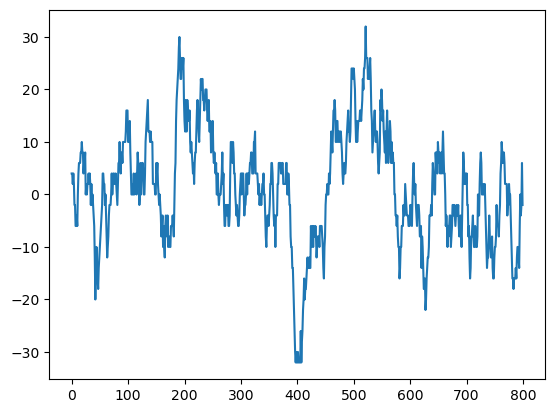

In [17]:
np.random.seed(42)

size=200
initial_state = np.random.choice([-1, 1], size=size)
num_samples = int(1e3)
burnin = 0.2
#T = np.arange(1,20)

samples, sum_of_spins, energy_values = metropolis_hastings(
    energy,
    proposed_sequence,
    initial_state,
    num_samples,
    burnin=burnin,
    T = 10.0
)

plt.plot(sum_of_spins)

/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_5399/2781124860.py:36: RuntimeWarning: overflow encountered in exp
  if np.exp(-2*(prop_energy-curr_energy)/T) < accept_threshold:


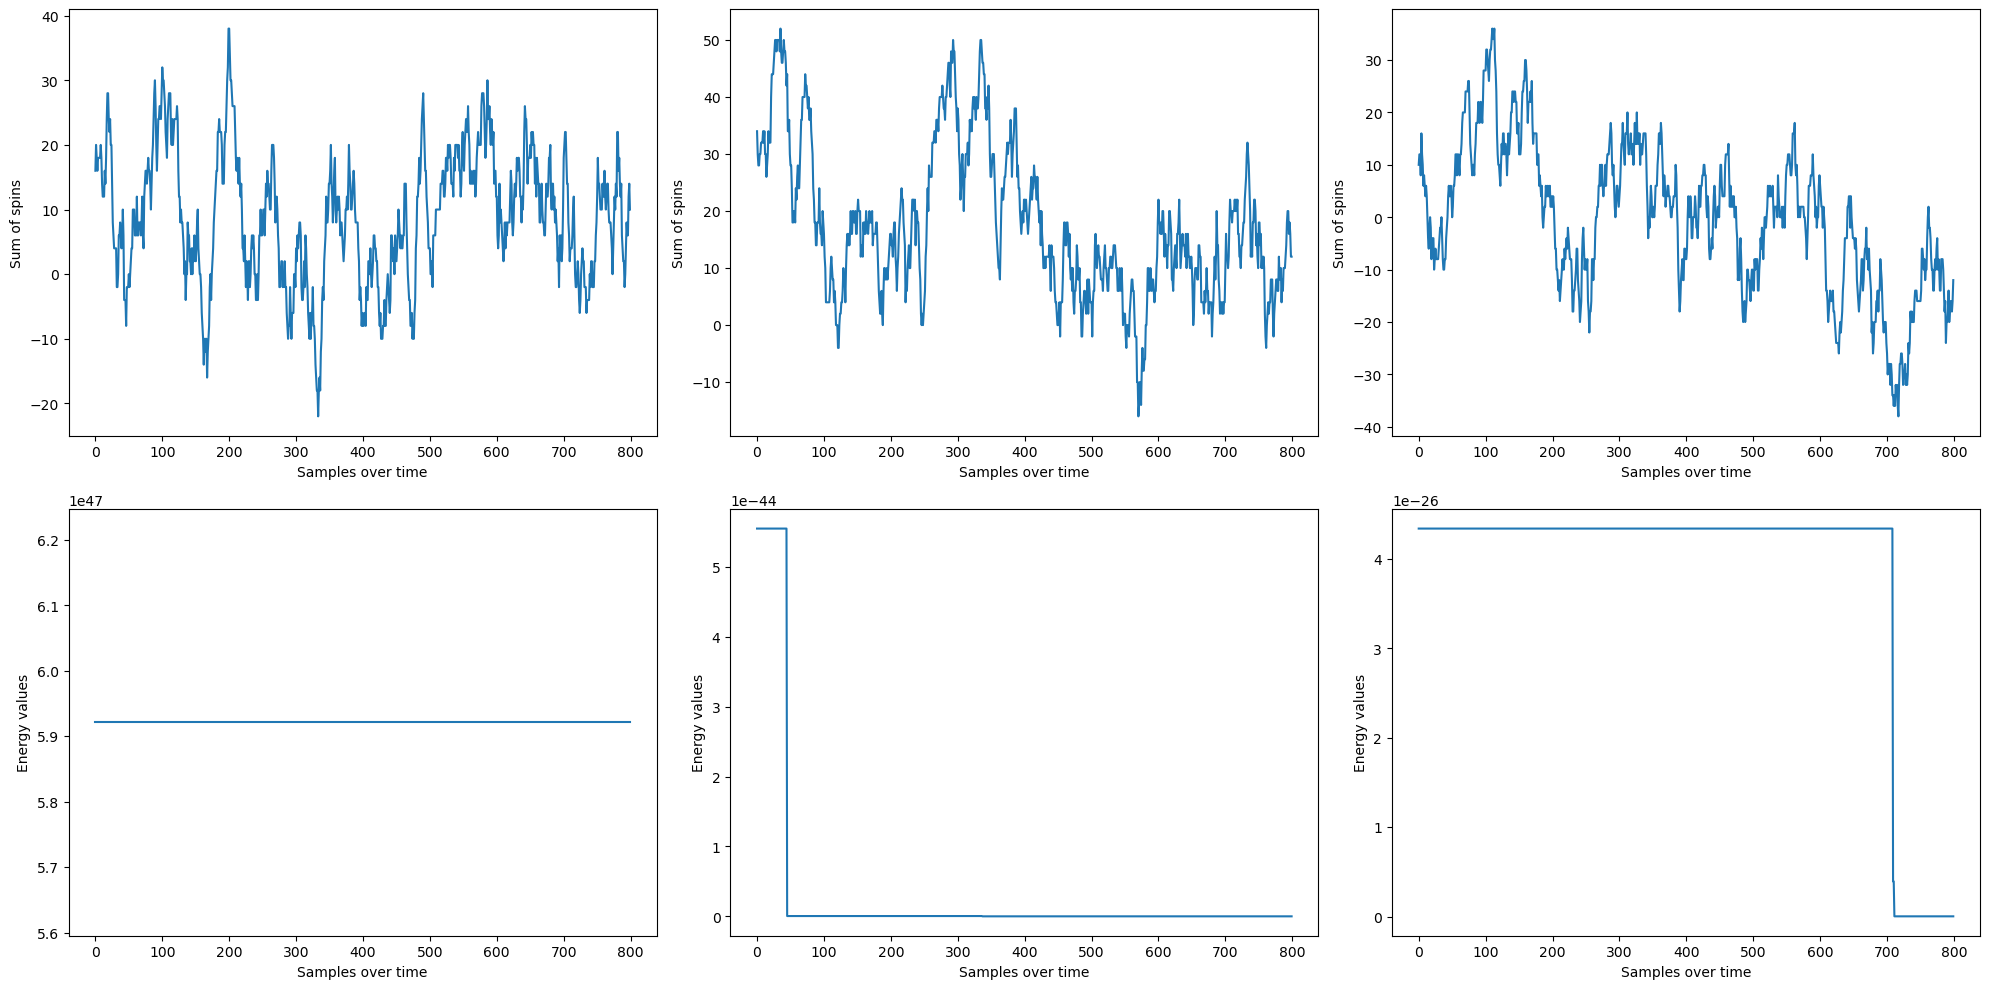

In [18]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
T = [1,10,20]
for i in range(3):
    samples, sum_of_spins, energy_values = metropolis_hastings(
    energy,
    proposed_sequence,
    initial_state,
    num_samples,
    burnin=burnin,
    T = T[i]
)
    ax[0,i].plot(sum_of_spins)
    ax[0,i].set_xlabel("Samples over time")
    ax[0,i].set_ylabel("Sum of spins")

    ax[1,i].plot(energy_values)
    ax[1,i].set_xlabel("Samples over time")
    ax[1,i].set_ylabel("Energy values")
    
plt.tight_layout()
plt.show()


## Covariances

In [15]:
# covariance for each site within a sample
C = samples[0]
tmp_matcontact = np.zeros([10, 10])
print(tmp_matcontact)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
